In [12]:
# Homework 2
# Group 18

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from PIL import Image, ImageEnhance
import random

In [14]:
# Set Constants
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

LATENT_DIM = 256
BATCH_SIZE = 20
LEARNING_RATE = 1 * 1e-3
NUM_EPOCHS = 30
DROPOUT_RATE = 0
WEIGHT_DECAY = 1e-5
IMAGE_PIXEL_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Loading Data
keywords = ['face']
dataset = load_dataset('valhalla/emoji-dataset')['train']
imgs = []
for data in dataset:
    title = data['text'].lower()
    if any (k in title for k in keywords):
        img = data['image'].convert('RGB').resize((IMAGE_PIXEL_SIZE, IMAGE_PIXEL_SIZE), Image.LANCZOS)
        imgs.append(img)
X = np.stack(imgs)
print(X.shape)

(204, 128, 128, 3)


In [ ]:
# Data augmentation
original_size = len(imgs)
train_size_target = 600
val_size_target = 200
test_size_target = 200
total_target = train_size_target + val_size_target + test_size_target

indices = np.arange(len(imgs))
np.random.shuffle(indices)
train_size = int(0.6 * original_size)
val_size = int(0.2 * original_size)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]
train_imgs_orig = [imgs[i] for i in train_indices]
val_imgs_orig = [imgs[i] for i in val_indices]
test_imgs_orig = [imgs[i] for i in test_indices]

def augment_image(img):
    augmented = []
    augmented.append(img)
    augmented.append(img.rotate(30, fillcolor=(255, 255, 255)))
    augmented.append(img.rotate(-30, fillcolor=(255, 255, 255)))
    augmented.append(ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2)))
    augmented.append(ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2)))
    return augmented

def augment_dataset(imgs, target_size):
    augmented = []
    imgs_shuffled = imgs.copy()
    random.shuffle(imgs_shuffled)
    while(len(augmented)) < target_size:
        for img in imgs_shuffled:
            if len(augmented) >= target_size:
                break
            aug_imgs = augment_image(img)
            augmented.extend(aug_imgs)
    return augmented

train_imgs = augment_dataset(train_imgs_orig, train_size_target)
val_imgs = augment_dataset(val_imgs_orig, val_size_target)
test_imgs = augment_dataset(test_imgs_orig, test_size_target)
random.shuffle(train_imgs)
random.shuffle(val_imgs)
random.shuffle(test_imgs)

transform = T.Compose([
    T.ToTensor(),
])
X_train = torch.stack([transform(img) for img in train_imgs])
X_val = torch.stack([transform(img) for img in val_imgs])
X_test = torch.stack([transform(img) for img in test_imgs])
train_dataset = TensorDataset(X_train, X_train)
val_dataset = TensorDataset(X_val, X_val)
test_dataset = TensorDataset(X_test, X_test)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [17]:
# define model
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim = LATENT_DIM):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),


            nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),
        )

        self.latent_dim = latent_dim
        self.flatten = nn.Flatten()
        self.fc_encode = nn.Linear(256 * (IMAGE_PIXEL_SIZE // 16) * (IMAGE_PIXEL_SIZE // 16), self.latent_dim)
        self.fc_decode = nn.Linear(self.latent_dim, (256 * (IMAGE_PIXEL_SIZE // 16) * (IMAGE_PIXEL_SIZE // 16)))
        self.unflatten = nn.Unflatten(1, (256 ,(IMAGE_PIXEL_SIZE // 16) ,(IMAGE_PIXEL_SIZE // 16)))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.ConvTranspose2d(32, 3, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        z = self.fc_encode(x)
        return z
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

In [18]:
# Train the model
model = ConvAutoencoder(latent_dim = LATENT_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc = f"Epoch {epoch + 1}/{NUM_EPOCHS}")):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        recon, _ = model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(DEVICE)
            recon, _ = model(data)
            loss = criterion(recon, data)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Train Loss : {train_loss:.6f}, Val Loss : {val_loss:.6f}")

model.eval()
test_loss = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(DEVICE)
        recon, _ = model(data)
        loss = criterion(recon, data)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.6f}")

Epoch 1/30: 100%|██████████| 30/30 [00:05<00:00,  5.58it/s]



Train Loss : 0.119923, Val Loss : 0.085264


Epoch 2/30: 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]



Train Loss : 0.064752, Val Loss : 0.049478


Epoch 3/30: 100%|██████████| 30/30 [00:05<00:00,  5.65it/s]


Train Loss : 0.042999, Val Loss : 0.037524


Epoch 4/30: 100%|██████████| 30/30 [00:05<00:00,  5.68it/s]


Train Loss : 0.032490, Val Loss : 0.031435


Epoch 5/30: 100%|██████████| 30/30 [00:05<00:00,  5.62it/s]


Train Loss : 0.026998, Val Loss : 0.028319


Epoch 6/30: 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]



Train Loss : 0.023687, Val Loss : 0.026603


Epoch 7/30: 100%|██████████| 30/30 [00:05<00:00,  5.68it/s]


Train Loss : 0.023827, Val Loss : 0.025242


Epoch 8/30: 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]



Train Loss : 0.020080, Val Loss : 0.023739


Epoch 9/30: 100%|██████████| 30/30 [00:05<00:00,  5.52it/s]



Train Loss : 0.018490, Val Loss : 0.022651


Epoch 10/30: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]



Train Loss : 0.017173, Val Loss : 0.023160


Epoch 11/30: 100%|██████████| 30/30 [00:05<00:00,  5.37it/s]



Train Loss : 0.015819, Val Loss : 0.021911


Epoch 12/30: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s]


Train Loss : 0.014294, Val Loss : 0.020857


Epoch 13/30: 100%|██████████| 30/30 [00:05<00:00,  5.49it/s]



Train Loss : 0.013290, Val Loss : 0.020270


Epoch 14/30: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s]



Train Loss : 0.012868, Val Loss : 0.021160


Epoch 15/30: 100%|██████████| 30/30 [00:05<00:00,  5.59it/s]



Train Loss : 0.012697, Val Loss : 0.021595


Epoch 16/30: 100%|██████████| 30/30 [00:05<00:00,  5.49it/s]



Train Loss : 0.012443, Val Loss : 0.020330


Epoch 17/30: 100%|██████████| 30/30 [00:05<00:00,  5.52it/s]


Train Loss : 0.010795, Val Loss : 0.019620


Epoch 18/30: 100%|██████████| 30/30 [00:05<00:00,  5.54it/s]


Train Loss : 0.009829, Val Loss : 0.019454


Epoch 19/30: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]



Train Loss : 0.009243, Val Loss : 0.019077


Epoch 20/30: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]



Train Loss : 0.008697, Val Loss : 0.019225


Epoch 21/30: 100%|██████████| 30/30 [00:05<00:00,  5.51it/s]


Train Loss : 0.008996, Val Loss : 0.020318


Epoch 22/30: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s]



Train Loss : 0.008425, Val Loss : 0.019747


Epoch 23/30: 100%|██████████| 30/30 [00:05<00:00,  5.49it/s]



Train Loss : 0.008245, Val Loss : 0.020250


Epoch 24/30: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]



Train Loss : 0.008638, Val Loss : 0.021077


Epoch 25/30: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]



Train Loss : 0.008215, Val Loss : 0.019336


Epoch 26/30: 100%|██████████| 30/30 [00:05<00:00,  5.49it/s]



Train Loss : 0.007442, Val Loss : 0.019300


Epoch 27/30: 100%|██████████| 30/30 [00:05<00:00,  5.53it/s]



Train Loss : 0.007202, Val Loss : 0.018917


Epoch 28/30: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]



Train Loss : 0.006711, Val Loss : 0.018181


Epoch 29/30: 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]



Train Loss : 0.006671, Val Loss : 0.019677


Epoch 30/30: 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]



Train Loss : 0.006740, Val Loss : 0.019514
Test Loss: 0.018726
Test Loss: 0.018726


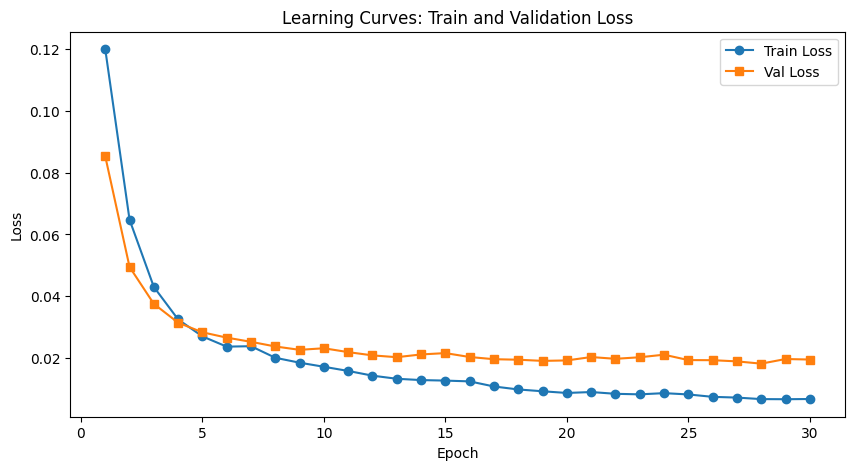

In [19]:
plt.figure(figsize = (10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label = 'Train Loss', marker = 'o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label = 'Val Loss', marker = 's')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Learning Curves: Train and Validation Loss")
plt.savefig('q1_learning_curves.png', dpi = 300, bbox_inches = 'tight')
plt.show()

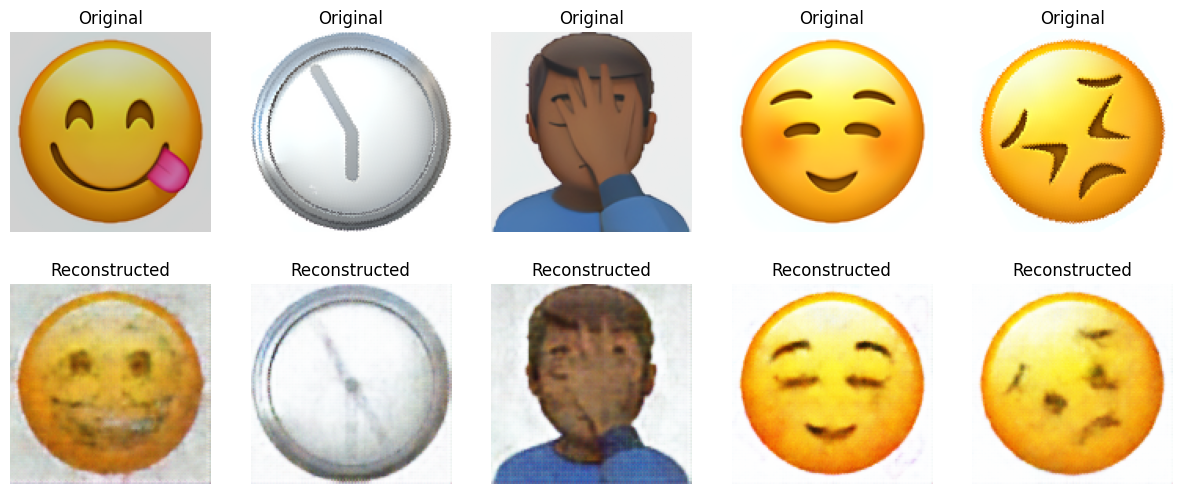

In [20]:
model.eval()
with torch.no_grad():
    sample_data = X_test[:5].to(DEVICE)
    recon_data, _ = model(sample_data)
    sample_data = sample_data.cpu().numpy()
    recon_data = recon_data.cpu().numpy()
    fig, axes = plt.subplots(2, 5, figsize = (15, 6))
    for i in range(5):
        axes[0, i].imshow(np.transpose(sample_data[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        axes[1, i].imshow(np.transpose(recon_data[i], (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
    plt.savefig('q1_reconstructions.png', dpi = 300, bbox_inches = 'tight')
    plt.show()

# Question 1 Free Response
## describe your dataset and the steps that you used to create it,
The base dataset is constructed from searching all emojis that are related to the keyword “face”. However, there are only about 200 emojis found, so we need to create about 4 times more emojis by proper data augmentation to fulfill the requirements of data inputs. The augmentations we adopted are rotation clockwise/counterclockwise for 30 degrees, random brightness adjustments, and random contrast adjustments. After these steps, augmented images are packed as tensors, and getting ready for the next step. In summary, for each emoji related to “face”, 4 more augmented copies will be fed to the model. 
## provide a summary of your architecture,
The model has a symmetrical structure of encoder and decoder, which aims to compress and reconstruct the given image. For the encoder, it has four convolutional layers which all have stride of 2, kernel of size 3*3, padding of 1. Batch normalizations occurred after each layer, and LeakyReLU is used as the activation function between layers. In total, the encoder transforms the input data from 3 channels into 256 channels. After flattening the encoded output, the fully connected layers project it to a 256-dimensional latent vector, prepared for the later reconstruction. The decoder mirrors the structure of the encoder, but in the reversed ordering. The decoder will span the encoded features back to the original image size, by ending with a sigmoid activation function. 
## discuss and explain your design choices,
The stride-2 convolutional layers allow the model to learn downsampling parameters in a straightforward way, batch normalization is used for gradient stabilization and faster convergence, and LeakyReLU helps the gradient flow. A 256-dimensional latent vector is the proper size of the bottleneck while 128-dimensional latent vectors will blur the reconstruction and 512-dimensional latent vectors will give unacceptably much redundant information leading to weird dots appearing in the reconstructed images.
## list hyper-parameters used in the model,
Epoch 30: We initially trained the model for 50 epochs to optimize performance, but observed that it converged well before reaching that point. Therefore, we reduced the training duration to 30 epochs to accelerate the process without sacrificing accuracy.
Batch Size 20: We decided to employ a smaller batch size to maintain computational efficiency while ensuring the model to generalize better. However, you may observe fluctuations in loss due to noise introduced in training process 
Optimizer Adam : The Adam optimizer utilizes momentum. It ensures a faster and more stable converge compared to traditional weight decay. 
Learning Rate 1e-3: This prevents overshooting from minimum, ensuring learning speed and stability during the training. Combined with Adam’s adaptive adjustment, it ensures smooth and consistent progress during training.
Weight Decay 1e-5: A small term that can help model prevent overfitting
Loss: MSE, as requirement by assignment  
Latent Dim 256: Throughout experimentation, we observed that a high latent dim would result in diminishing return, while a small latent dim would lead to loss of detail, 256 is a number that balances the two considerations. 
## plot learning curves for training and validation loss as a function of training epochs,
See Attached in ipynb file 
## provide the final average error of your autoencoder on your test set,
See Attached in ipynb file 
## provide a side-by-side example of 5 input and output images, and
See Attached in ipynb file 
## discuss any decisions or observations that you find relevant
Several improvements can be made to enhance the model’s robustness and generalization. Currently, the dropout rate is set to 0; introducing dropout could help prevent overfitting and improve the model’s ability to generalize to unseen data. Additionally, adding residual connections may mitigate vanishing gradients and stabilize training in deeper network layers. During experimentation, we observed that brightness augmentation significantly affected reconstruction quality, occasionally introducing visual noise and distortions. To address this, we suggest applying a broader and more balanced range of brightness adjustments during data augmentation to help the autoencoder better adapt to lighting variations and maintain consistent output quality.

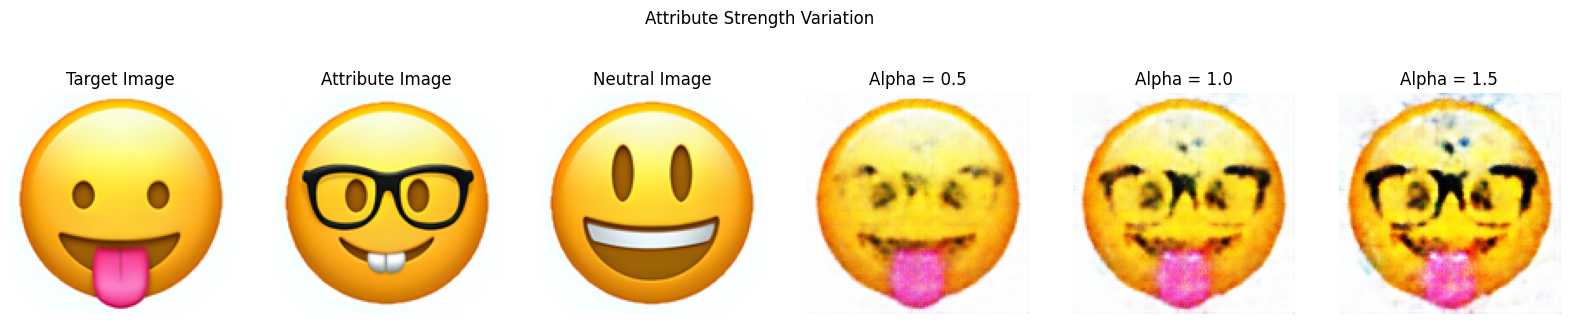

In [21]:
# Question 2
keywords = ['face']
all_emojis = []
for data in dataset:
    title = data['text'].lower()
    if any(k in title for k in keywords):
        img = data['image'].convert('RGB').resize((IMAGE_PIXEL_SIZE, IMAGE_PIXEL_SIZE), Image.LANCZOS)
        all_emojis.append({
            'title': title,
            'image': img
        })
def find_emoji_by_keyword(keyword, emojis):
    matches = []
    for i, emoji in enumerate(emojis):
        if keyword.lower() in emoji['title'].lower():
            matches.append((i, emoji['title']))
    return matches

ATTRIBUTE_KEYWORD = 'nerd'
NEUTRAL_KEYWORD = 'smiling'
TARGET_KEYWORD = 'tongue'
ATTRIBUTE_MATCHES = find_emoji_by_keyword(ATTRIBUTE_KEYWORD, all_emojis)
NEUTRAL_MATCHES = find_emoji_by_keyword(NEUTRAL_KEYWORD, all_emojis)
TARGET_MATCHES = find_emoji_by_keyword(TARGET_KEYWORD, all_emojis)
ATTRIBUTE_IDX = ATTRIBUTE_MATCHES[0][0]
NEUTRAL_IDX = NEUTRAL_MATCHES[0][0]
TARGET_IDX = TARGET_MATCHES[0][0]
ATTRIBUTE_IMAGE = all_emojis[ATTRIBUTE_IDX]['image']
NEUTRAL_IMAGE = all_emojis[NEUTRAL_IDX]['image']
TARGET_IMAGE = all_emojis[TARGET_IDX]['image']

transform = T.ToTensor()
attribute_tensor = transform(ATTRIBUTE_IMAGE).unsqueeze(0).to(DEVICE)
neutral_tensor = transform(NEUTRAL_IMAGE).unsqueeze(0).to(DEVICE)
target_tensor = transform(TARGET_IMAGE).unsqueeze(0).to(DEVICE)

alphas = [0.5, 1.0, 1.5]
fig, axes = plt.subplots(1, len(alphas) + 3, figsize = (4 * (len(alphas) + 2), 4))
axes[0].imshow(TARGET_IMAGE)
axes[0].set_title('Target Image')
axes[0].axis('off')
axes[1].imshow(ATTRIBUTE_IMAGE)
axes[1].set_title('Attribute Image')
axes[1].axis('off')
axes[2].imshow(NEUTRAL_IMAGE)
axes[2].set_title('Neutral Image')
axes[2].axis('off')

z_attribute = model.encode(attribute_tensor)
z_neutral = model.encode(neutral_tensor)
z_target = model.encode(target_tensor)
with torch.no_grad():
    for i, alpha in enumerate(alphas):
        z_composite = z_target + alpha * (z_attribute - z_neutral)
        recon_composite = model.decode(z_composite)
        recon_composite = recon_composite.cpu().squeeze(0).permute(1, 2, 0).numpy()
        axes[i + 3].imshow(recon_composite)
        axes[i + 3].set_title(f'Alpha = {alpha}')
        axes[i + 3].axis('off')
plt.suptitle(f'Attribute Strength Variation')
plt.savefig('q2_attribute_manipulation.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# Question 2 Free Response
## specify which attribute you selected, the vector arithmetic applied and the resulting
We are using the “nerd with glasses” as the selected attribute. The vector arithmetic used is Z(composite) = Z(Target) + (Z(Attribute) - Z(Neutral))*alpha, where alpha is an integer we picked. After picking Nerd as an attribute, Smiling as neutral, and tongue as target, we eventually obtain a tongue image with glasses on. The optimal alpha value, after trials, is 1 among [0.5, 1.5]. We discovered that a higher/lower alpha value will significantly blur the resulting image, and 1 is the optimal choice.

## image(s) as displayed above,
As attached in ipynb file.

## provide a qualitative evaluation of your composite image, and
Our composite image successfully captures the key feature in Nerd attribute, which is the glasses worn. After subtracting the neutral smiling face, the intention is to remove duplicated info about the smiling emoji and to keep only the glasses. When added with our target of a tongue emoji, the expected result is exactly the tongue emoji with glasses on. Considering that, our model has done pretty good on that. We note that the output images are slightly blurred and the feature of the eyes/mouths is not extremely clear, which may be due to the slight difference between the attribute and neutral images. If the smiling pattern becomes more similar, we anticipate the result to be better.

## discuss ways to improve the quality of your generated image.
The key to improvement may stay in the structure of our autoencoder. For now, we note the facial details, though can be roughly captured, are not precise enough. For instance, the mouth details can be rather different than the input images in our reconstructed examples. To improve on that, we find residue connection may be needed so that the features can be better preserved and learned by the network. Meanwhile, deeper neural networks and greater latent spaces can make the result better, but we doubt it would only marginally improve that. As discussed earlier, using Latent_dim = 512 makes the output image less clear. A wiser choice of parameters may be needed eventually.
